# GRN Inference: Data Alignment and Ground Truth Exploration

## Objective
1. Standardize column names across all datasets
2. Convert all gene names to uppercase for consistency
3. Explore ChIP-Atlas and BEELINE ground truth distributions to identify patterns

**Key Question:** What patterns in the ground truth data can we exploit to predict TF-TG edges that match ChIP-seq binding to nearest gene TSS?

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option("display.max_columns", 15)
pd.set_option("display.max_rows", 100)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Raw Data

In [36]:
# File paths
sliding_window_file = "data/processed/mESC_no_scale_linear/E7.5_rep1/sliding_window.parquet"
peak_to_gene_dist_file = "data/processed/mESC_no_scale_linear/E7.5_rep1/peak_to_gene_dist.parquet"
gene_tss_location_file = "data/genome_data/genome_annotation/mm10/gene_tss.bed"
peak_location_file = "data/processed/mESC_no_scale_linear/E7.5_rep1/peaks.bed"
rna_file = "data/raw/mESC_no_scale_linear/E7.5_rep1/scRNA_seq_processed.parquet"
atac_file = "data/raw/mESC_no_scale_linear/E7.5_rep1/scATAC_seq_processed.parquet"

chip_atlas_raw_file = "data/ground_truth_files/chipatlas_mESC.csv"
beeline_raw_file = "data/ground_truth_files/mESC_beeline_ChIP-seq.csv"
chip_atlas_tf_peak_tg_file = "data/ground_truth_files/chip_atlas_tf_peak_tg_dist.csv"
chip_atlas_beeline_shared_peaks_file = "data/ground_truth_files/chipatlas_beeline_mESC_shared_edges.csv"
bear_grn_ground_truth_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.GRN_BENCHMARKING.MOELLER/testing_bear_grn/GROUND.TRUTHS/filtered_RN111_and_RN112_mESC_E7.5_rep1.tsv"

print("Loading data files...")
print("This may take a few minutes for large files...\n")

# Load data
sliding_window_df = pd.read_parquet(sliding_window_file)
print(f"✓ Loaded sliding_window_df: {sliding_window_df.shape}")

peak_to_gene_dist_df = pd.read_parquet(peak_to_gene_dist_file)
print(f"✓ Loaded peak_to_gene_dist_df: {peak_to_gene_dist_df.shape}")

gene_tss_location_df = pd.read_csv(gene_tss_location_file, sep="\t", header=None, 
                                     names=['chrom', 'start', 'end', 'gene_name'])
print(f"✓ Loaded gene_tss_location_df: {gene_tss_location_df.shape}")

peak_location_df = pd.read_csv(peak_location_file, sep="\t", header=None,
                                names=['chrom', 'start', 'end', 'peak_id'])
print(f"✓ Loaded peak_location_df: {peak_location_df.shape}")

atac_df = pd.read_parquet(atac_file)
print(f"✓ Loaded atac_df: {atac_df.shape}")

rna_df = pd.read_parquet(rna_file)
print(f"✓ Loaded rna_df: {rna_df.shape}")

chip_atlas_df = pd.read_csv(chip_atlas_raw_file)
print(f"✓ Loaded chip_atlas_df: {chip_atlas_df.shape}")

chip_atlas_tf_peak_tg_df = pd.read_csv(chip_atlas_tf_peak_tg_file)
print(f"✓ Loaded chip_atlas_tf_peak_tg_df: {chip_atlas_tf_peak_tg_df.shape}")

beeline_df = pd.read_csv(beeline_raw_file)
print(f"✓ Loaded beeline_df: {beeline_df.shape}")

chip_atlas_beeline_shared_peaks_df = pd.read_csv(chip_atlas_beeline_shared_peaks_file)
print(f"✓ Loaded chip_atlas_beeline_shared_peaks_df: {chip_atlas_beeline_shared_peaks_df.shape}")

bear_grn_ground_truth_df = pd.read_csv(bear_grn_ground_truth_file, sep="\t")
print(f"✓ Loaded bear_grn_ground_truth_df: {bear_grn_ground_truth_df.shape}")

print("\n✓ All data files loaded successfully!")

Loading data files...
This may take a few minutes for large files...

✓ Loaded sliding_window_df: (237591400, 3)
✓ Loaded peak_to_gene_dist_df: (31182, 10)
✓ Loaded gene_tss_location_df: (25120, 4)
✓ Loaded peak_location_df: (57324, 4)
✓ Loaded atac_df: (57324, 7411)
✓ Loaded rna_df: (2925, 7411)
✓ Loaded chip_atlas_df: (7624391, 2)
✓ Loaded chip_atlas_tf_peak_tg_df: (7734466, 4)
✓ Loaded beeline_df: (977841, 2)
✓ Loaded chip_atlas_beeline_shared_peaks_df: (1721462, 5)
✓ Loaded bear_grn_ground_truth_df: (1018410, 2)

✓ All data files loaded successfully!


## 2. Standardize Column Names and Convert to Uppercase

**Standardization Rules:**
- TF columns → `TF`
- TG columns → `TG`
- Peak columns → `peak_id`
- Peak/gene chromosomes → `peak_chrom`/`gene_chrom` or `chrom`
- Peak/gene start → `peak_start`/`gene_start` or `start`
- Peak/gene end → `peak_end`/`gene_end` or `end`
- All gene names → UPPERCASE

In [3]:
# 1. Sliding Window DataFrame
sliding_window_df.columns = ['TF', 'peak_id', 'sliding_window_score']
sliding_window_df['TF'] = sliding_window_df['TF'].str.upper()
print("✓ Standardized sliding_window_df")
print(sliding_window_df.head(3))
print(f"  Shape: {sliding_window_df.shape}\n")

✓ Standardized sliding_window_df
    TF               peak_id  sliding_window_score
0  AHR  chr1:3142536-3143136                  -0.0
1  AHR  chr1:3553099-3553699                  -0.0
2  AHR  chr1:3584996-3585596                  -0.0
  Shape: (237591400, 3)



In [4]:
# 2. Peak to Gene Distance DataFrame
peak_to_gene_dist_df.rename(columns={
    'peak_chr': 'peak_chrom',
    'gene_chr': 'gene_chrom',
    'target_id': 'TG',
    'TSS_dist': 'tss_distance',
    'TSS_dist_score': 'tss_distance_score'
}, inplace=True)
peak_to_gene_dist_df['TG'] = peak_to_gene_dist_df['TG'].str.upper()
print("✓ Standardized peak_to_gene_dist_df")
print(peak_to_gene_dist_df.head(3))
print(f"  Shape: {peak_to_gene_dist_df.shape}\n")

✓ Standardized peak_to_gene_dist_df
      peak_chrom  peak_start   peak_end                   peak_id gene_chrom  \
23686       chr5   146230649  146231249  chr5:146230649-146231249       chr5   
22667       chr5   113772200  113772800  chr5:113772200-113772800       chr5   
10279      chr15    76080271   76080871   chr15:76080271-76080871      chr15   

       gene_start   gene_end     TG  tss_distance  tss_distance_score  
23686   146231249  146231249   CDK8             0              1.0000  
22667   113772800  113772800   ISCU             0              1.0000  
10279    76080870   76080870  PUF60             1              0.9998  
  Shape: (31182, 10)



In [5]:
# 3. Gene TSS Location DataFrame (already standardized in loading)
gene_tss_location_df['gene_name'] = gene_tss_location_df['gene_name'].str.upper()
print("✓ Standardized gene_tss_location_df")
print(gene_tss_location_df.head(3))
print(f"  Shape: {gene_tss_location_df.shape}\n")

✓ Standardized gene_tss_location_df
                  chrom  start   end gene_name
0  chr4_GL456350_random   1095  1095    CCL21B
1  chr4_GL456350_random   1131  1131   GM13304
2  chr4_JH584294_random   1717  1717    GM2506
  Shape: (25120, 4)



In [6]:
# 4. Peak Location DataFrame (already standardized in loading)
print("✓ Standardized peak_location_df")
print(peak_location_df.head(3))
print(f"  Shape: {peak_location_df.shape}\n")

✓ Standardized peak_location_df
  chrom    start      end               peak_id
0  chr1  3142536  3143136  chr1:3142536-3143136
1  chr1  3553099  3553699  chr1:3553099-3553699
2  chr1  3584996  3585596  chr1:3584996-3585596
  Shape: (57324, 4)



In [7]:
# 5. RNA Expression DataFrame
rna_df.index = rna_df.index.str.upper()
rna_df.index.name = 'gene_name'
print("✓ Standardized rna_df (gene names as uppercase index)")
print(f"  Shape: {rna_df.shape}")
print(f"  Genes: {rna_df.shape[0]}, Cells: {rna_df.shape[1]}\n")

✓ Standardized rna_df (gene names as uppercase index)
  Shape: (2925, 7411)
  Genes: 2925, Cells: 7411



In [8]:
# 6. ATAC Accessibility DataFrame
# Index is already peak_id format, column names are cell barcodes
atac_df.index.name = 'peak_id'
print("✓ Standardized atac_df (peak_id as index)")
print(f"  Shape: {atac_df.shape}")
print(f"  Peaks: {atac_df.shape[0]}, Cells: {atac_df.shape[1]}\n")

✓ Standardized atac_df (peak_id as index)
  Shape: (57324, 7411)
  Peaks: 57324, Cells: 7411



In [9]:
# 7. ChIP-Atlas Raw DataFrame
chip_atlas_df.rename(columns={
    'gene_id': 'TF'
}, inplace=True)
chip_atlas_df['TF'] = chip_atlas_df['TF'].str.upper()
print("✓ Standardized chip_atlas_df")
print(chip_atlas_df.head(3))
print(f"  Shape: {chip_atlas_df.shape}\n")

✓ Standardized chip_atlas_df
      TF               peak_id
0  SMAD4  chr1:3003564-3003922
1   CTCF  chr1:3012605-3012815
2   CTCF  chr1:3012635-3012824
  Shape: (7624391, 2)



In [37]:
#8. BEELINE Raw DataFrame
beeline_df.rename(columns={
    "Gene1": "TF",
    "Gene2": "TG"
}, inplace=True)
beeline_df['TF'] = beeline_df['TF'].str.upper()
beeline_df['TG'] = beeline_df['TG'].str.upper()
print("✓ Standardized beeline_df")
print(f"Shape: {beeline_df.shape}")

✓ Standardized beeline_df
Shape: (977841, 2)


In [10]:
# 8. ChIP-Atlas TF-peak-TG DataFrame
chip_atlas_tf_peak_tg_df.rename(columns={
    'source_id': 'TF',
    'target_id': 'TG',
    'distance': 'tss_distance'
}, inplace=True)
chip_atlas_tf_peak_tg_df['TF'] = chip_atlas_tf_peak_tg_df['TF'].str.upper()
chip_atlas_tf_peak_tg_df['TG'] = chip_atlas_tf_peak_tg_df['TG'].str.upper()
print("✓ Standardized chip_atlas_tf_peak_tg_df")
print(chip_atlas_tf_peak_tg_df.head(3))
print(f"  Shape: {chip_atlas_tf_peak_tg_df.shape}\n")

✓ Standardized chip_atlas_tf_peak_tg_df
      TF               peak_id    TG  tss_distance
0  SMAD4  chr1:3003564-3003922  XKR4        667576
1   CTCF  chr1:3012605-3012815  XKR4        658683
2   CTCF  chr1:3012635-3012824  XKR4        658674
  Shape: (7734466, 4)



In [11]:
# 9. ChIP-Atlas BEELINE Shared Peaks DataFrame
chip_atlas_beeline_shared_peaks_df.rename(columns={
    'source_id': 'TF',
    'target_id': 'TG'
}, inplace=True)
chip_atlas_beeline_shared_peaks_df['TF'] = chip_atlas_beeline_shared_peaks_df['TF'].str.upper()
chip_atlas_beeline_shared_peaks_df['TG'] = chip_atlas_beeline_shared_peaks_df['TG'].str.upper()
print("✓ Standardized chip_atlas_beeline_shared_peaks_df")
print(chip_atlas_beeline_shared_peaks_df.head(3))
print(f"  Shape: {chip_atlas_beeline_shared_peaks_df.shape}\n")

✓ Standardized chip_atlas_beeline_shared_peaks_df
      TF      TG  chrom      start        end
0  ASCL1   ACACB   chr5  114173037  114173222
1  ASCL1   ACACB   chr5  114173103  114173157
2  ASCL1  BTBD17  chr11  114795327  114795552
  Shape: (1721462, 5)



In [12]:
# 10. BEAR-GRN Ground Truth DataFrame
bear_grn_ground_truth_df.rename(columns={
    'Source': 'TF',
    'Target': 'TG'
}, inplace=True)
bear_grn_ground_truth_df['TF'] = bear_grn_ground_truth_df['TF'].str.upper()
bear_grn_ground_truth_df['TG'] = bear_grn_ground_truth_df['TG'].str.upper()
print("✓ Standardized bear_grn_ground_truth_df")
print(bear_grn_ground_truth_df.head(3))
print(f"  Shape: {bear_grn_ground_truth_df.shape}\n")

✓ Standardized bear_grn_ground_truth_df
      TF    TG
0   AFF3  XKR4
1  BTAF1  XKR4
2   CBX7  XKR4
  Shape: (1018410, 2)



In [13]:
print("="*80)
print("DATA STANDARDIZATION COMPLETE")
print("="*80)
print("\nAll DataFrames have:")
print("  ✓ Standardized column names")
print("  ✓ Gene names in UPPERCASE")
print("  ✓ Consistent naming conventions across datasets")

DATA STANDARDIZATION COMPLETE

All DataFrames have:
  ✓ Standardized column names
  ✓ Gene names in UPPERCASE
  ✓ Consistent naming conventions across datasets


## 3. Exploratory Data Analysis: Understanding Ground Truth Patterns

### Critical Question:
**What makes a TF-TG pair a "positive" edge in ChIP-Atlas/BEELINE?**

We need to understand:
1. **Distance distributions** - How far are ChIP peaks from the assigned gene TSS?
2. **Peak characteristics** - Do positive edges have more/stronger peaks nearby?
3. **Expression patterns** - Are TF/TG expression levels predictive?
4. **ATAC accessibility** - Is chromatin more accessible at positive edges?
5. **TF binding scores** - What sliding window scores distinguish true edges?

### 3.1 Basic Statistics: Ground Truth Files

In [ ]:
print("="*80)
print("GROUND TRUTH DATASET STATISTICS")
print("="*80)

print("\n1. BEAR-GRN Ground Truth (Evaluation Set):")
print(f"   Total edges: {len(bear_grn_ground_truth_df):,}")
print(f"   Unique TFs: {bear_grn_ground_truth_df['TF'].nunique():,}")
print(f"   Unique TGs: {bear_grn_ground_truth_df['TG'].nunique():,}")
print(f"   Edges per TF (mean): {len(bear_grn_ground_truth_df) / bear_grn_ground_truth_df['TF'].nunique():.1f}")

print("\n2. BEELINE TF-Peak-TG (with distances):")
print(f"   Total edges: {len(beeline_df):,}")
print(f"   Unique TFs: {beeline_df['TF'].nunique():,}")
print(f"   Unique TGs: {beeline_df['TG'].nunique():,}")
print(f"   Unique peaks: {beeline_df['peak_id'].nunique():,}")

print("\n3. ChIP-Atlas / BEELINE Shared Edges:")
print(f"   Total edges: {len(chip_atlas_beeline_shared_peaks_df):,}")
print(f"   Unique TF-TG pairs: {chip_atlas_beeline_shared_peaks_df[['TF', 'TG']].drop_duplicates().shape[0]:,}")
print(f"   Unique TFs: {chip_atlas_beeline_shared_peaks_df['TF'].nunique():,}")
print(f"   Unique TGs: {chip_atlas_beeline_shared_peaks_df['TG'].nunique():,}")

GROUND TRUTH DATASET STATISTICS

1. BEAR-GRN Ground Truth (Evaluation Set):
   Total edges: 1,018,410
   Unique TFs: 272
   Unique TGs: 28,565
   Edges per TF (mean): 3744.2

2. ChIP-Atlas TF-Peak-TG (with distances):
   Total edges: 7,734,466
   Unique TFs: 131
   Unique TGs: 24,821
   Unique peaks: 7,508,129

3. ChIP-Atlas / BEELINE Shared Edges:
   Total edges: 1,721,462
   Unique TF-TG pairs: 72,204
   Unique TFs: 40
   Unique TGs: 14,574


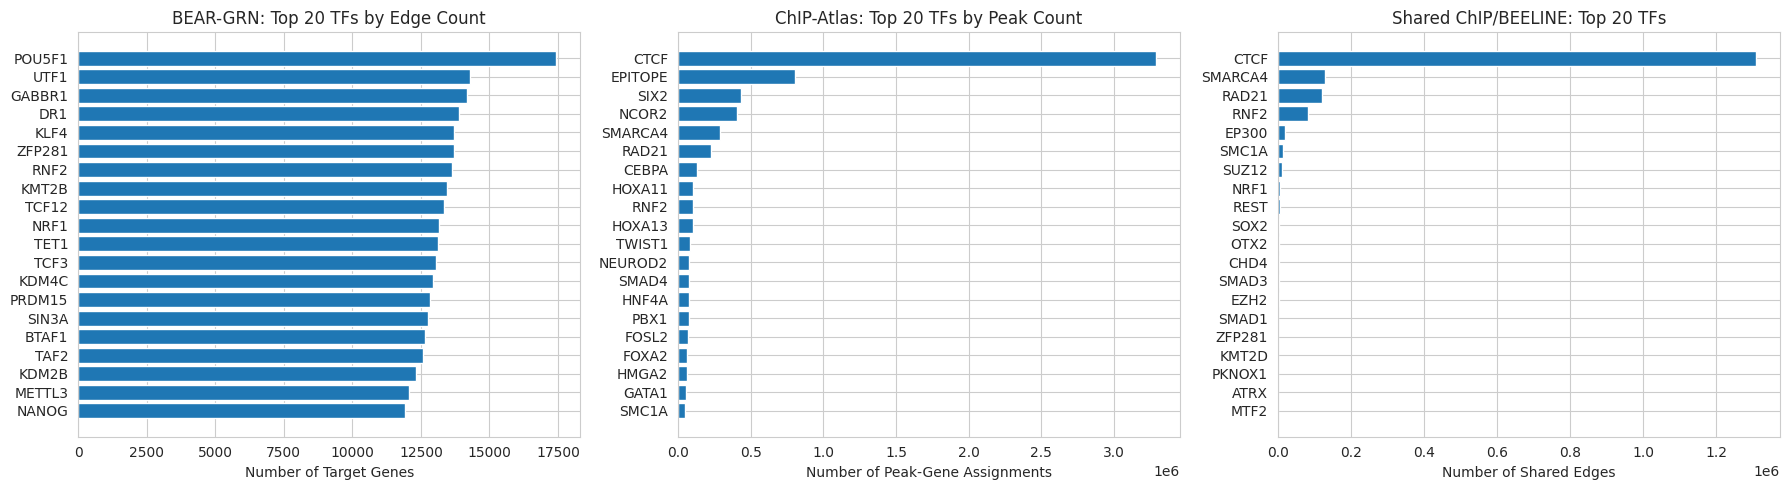


💡 Observation: Check if the same TFs dominate across datasets


In [15]:
# Top TFs by edge count in each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BEAR-GRN
bear_top_tfs = bear_grn_ground_truth_df['TF'].value_counts().head(20)
axes[0].barh(range(len(bear_top_tfs)), bear_top_tfs.values)
axes[0].set_yticks(range(len(bear_top_tfs)))
axes[0].set_yticklabels(bear_top_tfs.index)
axes[0].set_xlabel('Number of Target Genes')
axes[0].set_title('BEAR-GRN: Top 20 TFs by Edge Count')
axes[0].invert_yaxis()

# ChIP-Atlas TF-Peak-TG
chip_top_tfs = chip_atlas_tf_peak_tg_df['TF'].value_counts().head(20)
axes[1].barh(range(len(chip_top_tfs)), chip_top_tfs.values)
axes[1].set_yticks(range(len(chip_top_tfs)))
axes[1].set_yticklabels(chip_top_tfs.index)
axes[1].set_xlabel('Number of Peak-Gene Assignments')
axes[1].set_title('ChIP-Atlas: Top 20 TFs by Peak Count')
axes[1].invert_yaxis()

# ChIP-Atlas BEELINE Shared
shared_top_tfs = chip_atlas_beeline_shared_peaks_df['TF'].value_counts().head(20)
axes[2].barh(range(len(shared_top_tfs)), shared_top_tfs.values)
axes[2].set_yticks(range(len(shared_top_tfs)))
axes[2].set_yticklabels(shared_top_tfs.index)
axes[2].set_xlabel('Number of Shared Edges')
axes[2].set_title('Shared ChIP/BEELINE: Top 20 TFs')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n💡 Observation: Check if the same TFs dominate across datasets")

### 3.2 CRITICAL ANALYSIS: Distance Distribution

**This is the most important analysis** - BEELINE assigns peaks to nearest gene, so distance should be the primary discriminator.

In [16]:
print("="*80)
print("DISTANCE DISTRIBUTION ANALYSIS")
print("="*80)

# Summary statistics for ChIP-Atlas peak-to-TSS distances
print("\nChIP-Atlas Peak-to-TSS Distance Statistics:")
print(chip_atlas_tf_peak_tg_df['tss_distance'].describe())

# Key percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nDistance Percentiles:")
for p in percentiles:
    val = np.percentile(chip_atlas_tf_peak_tg_df['tss_distance'], p)
    print(f"  {p}th percentile: {val:,.0f} bp")

DISTANCE DISTRIBUTION ANALYSIS

ChIP-Atlas Peak-to-TSS Distance Statistics:
count    7.734466e+06
mean     6.551269e+04
std      1.366534e+05
min     -1.000000e+00
25%      3.108000e+03
50%      1.958400e+04
75%      6.406000e+04
max      2.075571e+06
Name: tss_distance, dtype: float64

Distance Percentiles:
  1th percentile: 0 bp
  5th percentile: 0 bp
  10th percentile: 0 bp
  25th percentile: 3,108 bp
  50th percentile: 19,584 bp
  75th percentile: 64,060 bp
  90th percentile: 168,675 bp
  95th percentile: 289,188 bp
  99th percentile: 682,580 bp


[clean] Dropped 24150 invalid distances (NaN/inf/negative). Kept 7710316.


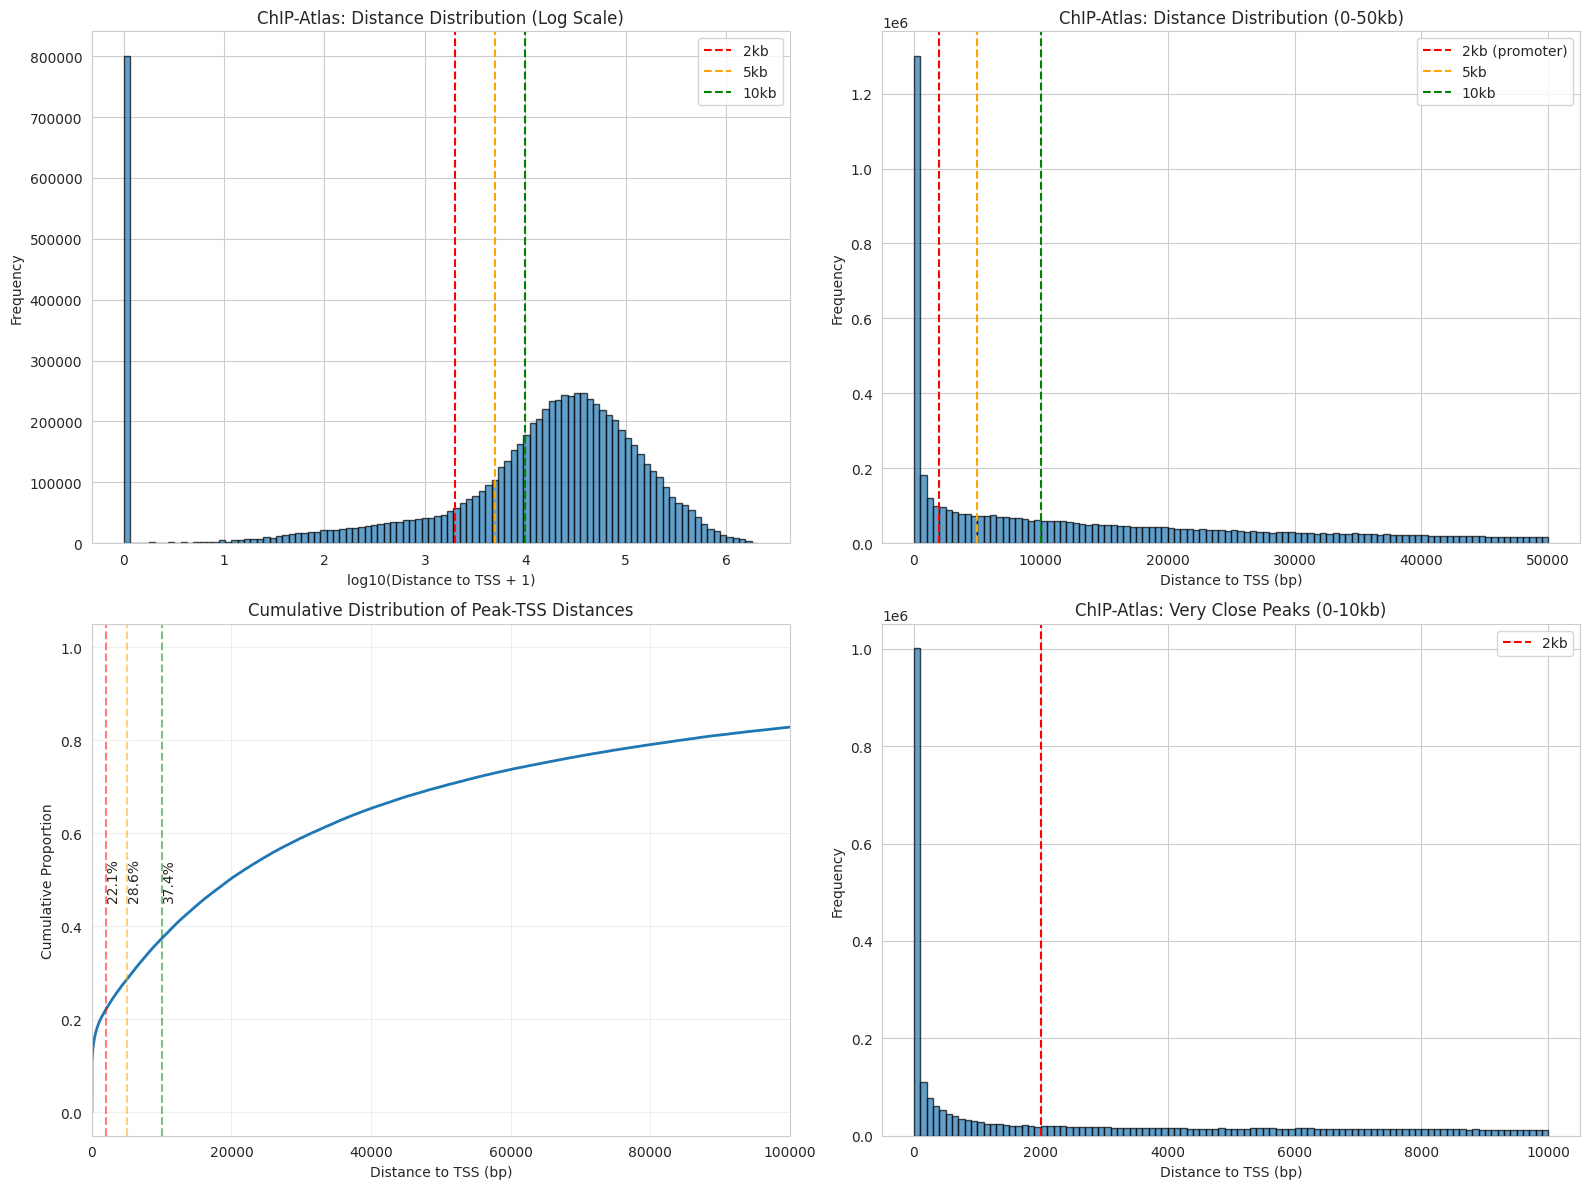


💡 KEY FINDINGS:
   22.1% of ChIP peaks are within 2kb of TSS (promoter region)
   28.6% of ChIP peaks are within 5kb of TSS
   37.4% of ChIP peaks are within 10kb of TSS
   70.0% of ChIP peaks are within 50kb of TSS

   → Distance is CRITICAL for classification


In [17]:
# Plot distance distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Full distribution (log scale)
distances_raw = chip_atlas_tf_peak_tg_df['tss_distance'].astype(float).values

# Keep only finite, non-negative distances
mask = np.isfinite(distances_raw) & (distances_raw >= 0)
distances = distances_raw[mask]

n_bad = (~mask).sum()
if n_bad > 0:
    print(f"[clean] Dropped {n_bad} invalid distances (NaN/inf/negative). Kept {len(distances)}.")

# Guard against empty input
if distances.size == 0:
    raise ValueError("No valid distances to plot after cleaning.")

# Precompute transforms / subsets
distances_log = np.log10(distances + 1.0)  # now safe (>= 0 → > 0 inside log1p base-10)

axes[0, 0].hist(distances_log, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('log10(Distance to TSS + 1)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('ChIP-Atlas: Distance Distribution (Log Scale)')
axes[0, 0].axvline(np.log10(2001), color='red', linestyle='--', label='2kb')
axes[0, 0].axvline(np.log10(5001), color='orange', linestyle='--', label='5kb')
axes[0, 0].axvline(np.log10(10001), color='green', linestyle='--', label='10kb')
axes[0, 0].legend()

# 2. Zoomed to 0-50kb (most relevant range)
distances_50kb = distances[distances <= 50000]
axes[0, 1].hist(distances_50kb, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Distance to TSS (bp)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('ChIP-Atlas: Distance Distribution (0-50kb)')
axes[0, 1].axvline(2000, color='red', linestyle='--', label='2kb (promoter)')
axes[0, 1].axvline(5000, color='orange', linestyle='--', label='5kb')
axes[0, 1].axvline(10000, color='green', linestyle='--', label='10kb')
axes[0, 1].legend()

# 3. Cumulative distribution
sorted_distances = np.sort(distances)
cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
axes[1, 0].plot(sorted_distances, cumulative, linewidth=2)
axes[1, 0].set_xlabel('Distance to TSS (bp)')
axes[1, 0].set_ylabel('Cumulative Proportion')
axes[1, 0].set_title('Cumulative Distribution of Peak-TSS Distances')
axes[1, 0].set_xlim(0, 100000)
axes[1, 0].axvline(2000, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axvline(5000, color='orange', linestyle='--', alpha=0.5)
axes[1, 0].axvline(10000, color='green', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Add percentage annotations
for dist, color in [(2000, 'red'), (5000, 'orange'), (10000, 'green')]:
    pct = (distances <= dist).sum() / len(distances) * 100
    axes[1, 0].text(dist, 0.5, f'{pct:.1f}%', rotation=90, va='center')

# 4. Very close peaks (0-10kb) - high resolution
distances_10kb = distances[distances <= 10000]
axes[1, 1].hist(distances_10kb, bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Distance to TSS (bp)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('ChIP-Atlas: Very Close Peaks (0-10kb)')
axes[1, 1].axvline(2000, color='red', linestyle='--', label='2kb')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Key statistics
within_2kb = (distances <= 2000).sum() / len(distances) * 100
within_5kb = (distances <= 5000).sum() / len(distances) * 100
within_10kb = (distances <= 10000).sum() / len(distances) * 100
within_50kb = (distances <= 50000).sum() / len(distances) * 100

print("\n💡 KEY FINDINGS:")
print(f"   {within_2kb:.1f}% of ChIP peaks are within 2kb of TSS (promoter region)")
print(f"   {within_5kb:.1f}% of ChIP peaks are within 5kb of TSS")
print(f"   {within_10kb:.1f}% of ChIP peaks are within 10kb of TSS")
print(f"   {within_50kb:.1f}% of ChIP peaks are within 50kb of TSS")
print("\n   → Distance is CRITICAL for classification")

### 3.3 Overlap Analysis: BEAR-GRN vs ChIP-Atlas

How much agreement is there between the evaluation set (BEAR-GRN) and ChIP-Atlas?

GROUND TRUTH OVERLAP ANALYSIS

Edge Set Sizes:
  BEAR-GRN unique edges: 1,015,666
  ChIP-Atlas unique edges: 771,359
  Overlapping edges: 76,944
  BEAR-GRN only: 938,722
  ChIP-Atlas only: 694,415

Overlap Percentages:
  7.6% of BEAR-GRN edges are in ChIP-Atlas
  10.0% of ChIP-Atlas edges are in BEAR-GRN


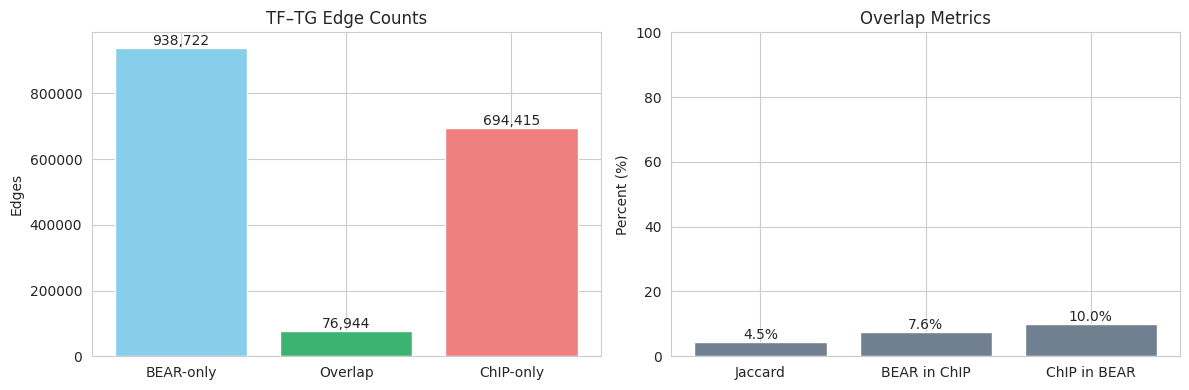


💡 Interpretation:
   High overlap → Model can potentially learn from ChIP-Atlas and generalize to BEAR-GRN
   Low overlap → Need to learn general principles, not just memorize edges


In [18]:
print("="*80)
print("GROUND TRUTH OVERLAP ANALYSIS")
print("="*80)

# Create TF-TG edge sets
bear_grn_edges = set(zip(bear_grn_ground_truth_df['TF'], bear_grn_ground_truth_df['TG']))
chip_atlas_edges = set(zip(chip_atlas_tf_peak_tg_df['TF'], chip_atlas_tf_peak_tg_df['TG']))

# Calculate overlap
overlap = bear_grn_edges.intersection(chip_atlas_edges)
bear_only = bear_grn_edges - chip_atlas_edges
chip_only = chip_atlas_edges - bear_grn_edges

print("\nEdge Set Sizes:")
print(f"  BEAR-GRN unique edges: {len(bear_grn_edges):,}")
print(f"  ChIP-Atlas unique edges: {len(chip_atlas_edges):,}")
print(f"  Overlapping edges: {len(overlap):,}")
print(f"  BEAR-GRN only: {len(bear_only):,}")
print(f"  ChIP-Atlas only: {len(chip_only):,}")

overlap_pct_bear = len(overlap) / len(bear_grn_edges) * 100
overlap_pct_chip = len(overlap) / len(chip_atlas_edges) * 100

print("\nOverlap Percentages:")
print(f"  {overlap_pct_bear:.1f}% of BEAR-GRN edges are in ChIP-Atlas")
print(f"  {overlap_pct_chip:.1f}% of ChIP-Atlas edges are in BEAR-GRN")

# Visualize overlap
bear_set = set(zip(bear_grn_ground_truth_df['TF'], bear_grn_ground_truth_df['TG']))
chip_set = set(zip(chip_atlas_tf_peak_tg_df['TF'], chip_atlas_tf_peak_tg_df['TG']))

overlap = bear_set & chip_set
bear_only = bear_set - chip_set
chip_only = chip_set - bear_set

counts = {
    "BEAR-only": len(bear_only),
    "Overlap":   len(overlap),
    "ChIP-only": len(chip_only),
}

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Counts
ax[0].bar(counts.keys(), counts.values(), color=["skyblue", "mediumseagreen", "lightcoral"])
ax[0].set_title("TF–TG Edge Counts")
ax[0].set_ylabel("Edges")
for i, v in enumerate(counts.values()):
    ax[0].text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=10)

# Percent overlap (Jaccard, BEAR recall in ChIP, ChIP recall in BEAR)
jaccard = len(overlap) / len(bear_set | chip_set) if (bear_set | chip_set) else 0.0
recall_bear_in_chip = len(overlap) / len(bear_set) if bear_set else 0.0
recall_chip_in_bear = len(overlap) / len(chip_set) if chip_set else 0.0

labels = ["Jaccard", "BEAR in ChIP", "ChIP in BEAR"]
vals = [jaccard, recall_bear_in_chip, recall_chip_in_bear]
ax[1].bar(labels, [v*100 for v in vals], color="slategray")
ax[1].set_ylim(0, 100)
ax[1].set_ylabel("Percent (%)")
ax[1].set_title("Overlap Metrics")
for i, v in enumerate(vals):
    ax[1].text(i, v*100, f"{v*100:.1f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   High overlap → Model can potentially learn from ChIP-Atlas and generalize to BEAR-GRN")
print("   Low overlap → Need to learn general principles, not just memorize edges")

### 3.4 TF Coverage Analysis

Which TFs are in both datasets? Which are unique?

TF COVERAGE ANALYSIS

TF Set Sizes:
  BEAR-GRN TFs: 272
  ChIP-Atlas TFs: 131
  Overlapping TFs: 44
  BEAR-GRN only TFs: 228
  ChIP-Atlas only TFs: 87

TFs with Expression Data:
  BEAR-GRN TFs with RNA-seq: 46 / 272 (16.9%)
  ChIP-Atlas TFs with RNA-seq: 40 / 131 (30.5%)

⚠️  BEAR-GRN TFs not in ChIP-Atlas (first 20):
   ['SUPT5', 'STAT3', 'LEO1', 'T', 'E2F4', 'CHD1', 'CDK9', 'GABBR1', 'TBX3', 'SIN3A', 'TUBA1A', 'MEN1', 'CXXC1', 'SMAD2', 'TGIF2', 'ZC3H11A', 'MORC3', 'PHC1', 'NSL1', 'BTAF1']
   → These TFs will have NO training data!


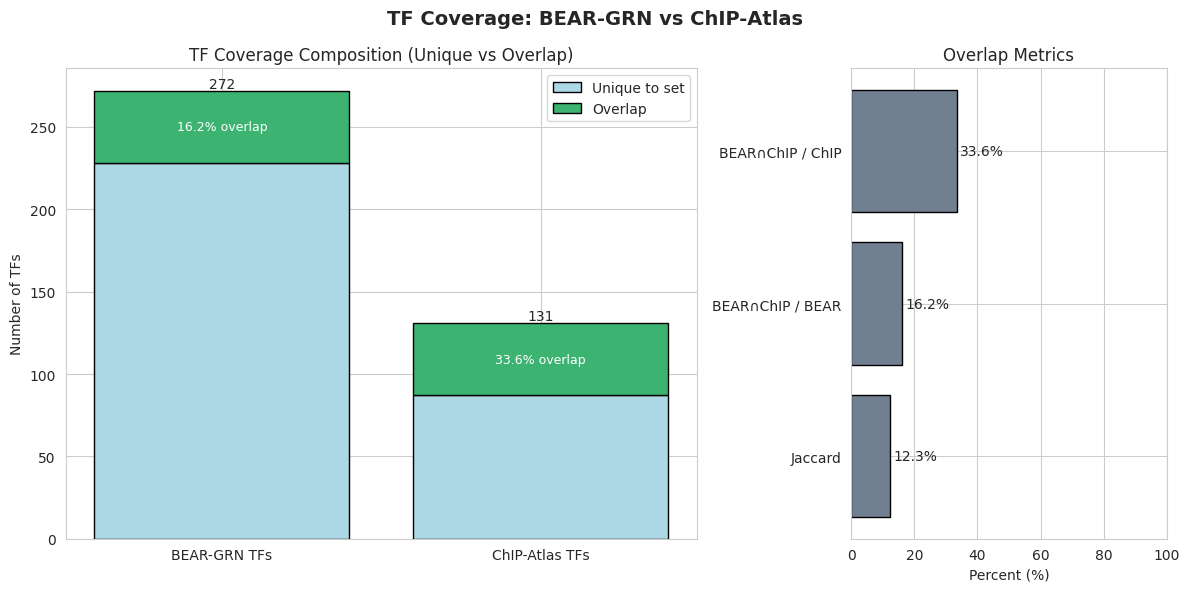

In [20]:
bear_tfs = set(bear_grn_ground_truth_df['TF'].unique())
chip_tfs = set(chip_atlas_tf_peak_tg_df['TF'].unique())
rna_genes = set(rna_df.index)

# TF overlaps
tf_overlap = bear_tfs.intersection(chip_tfs)
bear_only_tfs = bear_tfs - chip_tfs
chip_only_tfs = chip_tfs - bear_tfs

# TFs with expression data
bear_tfs_with_expr = bear_tfs.intersection(rna_genes)
chip_tfs_with_expr = chip_tfs.intersection(rna_genes)

print("="*80)
print("TF COVERAGE ANALYSIS")
print("="*80)

print("\nTF Set Sizes:")
print(f"  BEAR-GRN TFs: {len(bear_tfs)}")
print(f"  ChIP-Atlas TFs: {len(chip_tfs)}")
print(f"  Overlapping TFs: {len(tf_overlap)}")
print(f"  BEAR-GRN only TFs: {len(bear_only_tfs)}")
print(f"  ChIP-Atlas only TFs: {len(chip_only_tfs)}")

print("\nTFs with Expression Data:")
print(f"  BEAR-GRN TFs with RNA-seq: {len(bear_tfs_with_expr)} / {len(bear_tfs)} ({len(bear_tfs_with_expr)/len(bear_tfs)*100:.1f}%)")
print(f"  ChIP-Atlas TFs with RNA-seq: {len(chip_tfs_with_expr)} / {len(chip_tfs)} ({len(chip_tfs_with_expr)/len(chip_tfs)*100:.1f}%)")

if len(bear_only_tfs) > 0:
    print("\n⚠️  BEAR-GRN TFs not in ChIP-Atlas (first 20):")
    print(f"   {list(bear_only_tfs)[:20]}")
    print("   → These TFs will have NO training data!")

# Visualize TF overlap

bear_n  = len(bear_only_tfs) + len(tf_overlap)
chip_n  = len(chip_only_tfs) + len(tf_overlap)
overlap = len(tf_overlap)

# Metrics
jaccard = overlap / (bear_n + chip_n - overlap) if (bear_n + chip_n - overlap) else 0.0
recall_bear_in_chip = overlap / bear_n if bear_n else 0.0
recall_chip_in_bear = overlap / chip_n if chip_n else 0.0

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={"width_ratios": [2, 1]})

# --- Left: stacked bars showing coverage composition ---
left_ax = axes[0]
labels = ["BEAR-GRN TFs", "ChIP-Atlas TFs"]
unique_vals = [len(bear_only_tfs), len(chip_only_tfs)]
overlap_vals = [overlap, overlap]

bar1 = left_ax.bar(labels, unique_vals, color="lightblue", edgecolor="black", label="Unique to set")
bar2 = left_ax.bar(labels, overlap_vals, bottom=unique_vals, color="mediumseagreen", edgecolor="black", label="Overlap")

# Annotate counts on top
for i, total in enumerate([bear_n, chip_n]):
    left_ax.text(i, total, f"{total:,}", ha="center", va="bottom", fontsize=10)

# Annotate % overlap inside the overlap segment
for i, (u, o, total) in enumerate(zip(unique_vals, overlap_vals, [bear_n, chip_n])):
    if o > 0:
        pct = 100 * o / total
        left_ax.text(i, u + o/2, f"{pct:.1f}% overlap", ha="center", va="center", fontsize=9, color="white")

left_ax.set_ylabel("Number of TFs")
left_ax.set_title("TF Coverage Composition (Unique vs Overlap)")
left_ax.legend(loc="upper right")

# --- Right: overlap metrics ---
right_ax = axes[1]
metric_labels = ["Jaccard", "BEAR∩ChIP / BEAR", "BEAR∩ChIP / ChIP"]
metric_vals   = [jaccard*100, recall_bear_in_chip*100, recall_chip_in_bear*100]

bars = right_ax.barh(metric_labels, metric_vals, color="slategray", edgecolor="black")
right_ax.set_xlim(0, 100)
right_ax.set_xlabel("Percent (%)")
right_ax.set_title("Overlap Metrics")

# Add value labels
for b in bars:
    w = b.get_width()
    right_ax.text(w + 1, b.get_y() + b.get_height()/2, f"{w:.1f}%", va="center")

plt.suptitle("TF Coverage: BEAR-GRN vs ChIP-Atlas", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### 3.5 Create Positive/Negative Edge Analysis

To train a classifier, we need to understand what distinguishes positive from negative edges.

In [21]:
print("="*80)
print("POSITIVE vs NEGATIVE EDGE CHARACTERISTICS")
print("="*80)

# Define positive edges from ChIP-Atlas
positive_edges = chip_atlas_tf_peak_tg_df[['TF', 'TG', 'peak_id', 'tss_distance']].copy()
positive_edges['label'] = 1

print(f"\nPositive edges from ChIP-Atlas: {len(positive_edges):,}")
print(f"Unique TF-TG pairs: {positive_edges[['TF', 'TG']].drop_duplicates().shape[0]:,}")

# For comparison, we need to understand what ALL possible edges look like
# Let's get statistics on our peak_to_gene_dist_df which contains ALL peak-gene mappings

print("\n" + "="*80)
print("ALL PEAK-GENE MAPPINGS (Background)")
print("="*80)
print(f"Total peak-gene pairs: {len(peak_to_gene_dist_df):,}")
print(f"Unique peaks: {peak_to_gene_dist_df['peak_id'].nunique():,}")
print(f"Unique genes: {peak_to_gene_dist_df['TG'].nunique():,}")

print("\nDistance statistics (ALL peak-gene pairs):")
print(peak_to_gene_dist_df['tss_distance'].describe())

POSITIVE vs NEGATIVE EDGE CHARACTERISTICS

Positive edges from ChIP-Atlas: 7,734,466
Unique TF-TG pairs: 771,359

ALL PEAK-GENE MAPPINGS (Background)
Total peak-gene pairs: 31,182
Unique peaks: 20,561
Unique genes: 15,161

Distance statistics (ALL peak-gene pairs):
count    31182.000000
mean      9949.462735
std       5836.955252
min          0.000000
25%       4860.250000
50%       9983.000000
75%      15059.750000
max      20000.000000
Name: tss_distance, dtype: float64


In [22]:
# Merge peak-gene distances with sliding window scores to get features
print("\nMerging peak-gene distances with TF binding scores...")
print("(This may take a moment for large datasets)\n")

# Merge sliding window scores with peak-gene distances
feature_df = peak_to_gene_dist_df.merge(
    sliding_window_df[['TF', 'peak_id', 'sliding_window_score']],
    on='peak_id',
    how='left'
)

print(f"✓ Feature DataFrame created: {feature_df.shape}")
print("\nSample of merged data:")
print(feature_df.head())

# Handle missing sliding window scores (peaks without TF binding)
print(f"\nMissing sliding window scores: {feature_df['sliding_window_score'].isna().sum():,} ({feature_df['sliding_window_score'].isna().sum()/len(feature_df)*100:.1f}%)")
print("→ These are peaks where the TF has no predicted binding")


Merging peak-gene distances with TF binding scores...
(This may take a moment for large datasets)

✓ Feature DataFrame created: (129249390, 12)

Sample of merged data:
  peak_chrom  peak_start   peak_end                   peak_id gene_chrom  \
0       chr5   146230649  146231249  chr5:146230649-146231249       chr5   
1       chr5   146230649  146231249  chr5:146230649-146231249       chr5   
2       chr5   146230649  146231249  chr5:146230649-146231249       chr5   
3       chr5   146230649  146231249  chr5:146230649-146231249       chr5   
4       chr5   146230649  146231249  chr5:146230649-146231249       chr5   

   gene_start   gene_end    TG  tss_distance  tss_distance_score    TF  \
0   146231249  146231249  CDK8             0                 1.0   AHR   
1   146231249  146231249  CDK8             0                 1.0  ALX1   
2   146231249  146231249  CDK8             0                 1.0  ALX1   
3   146231249  146231249  CDK8             0                 1.0  ALX1   
4   

In [38]:
# Label edges as positive or negative based on ChIP-Atlas
# Positive: TF-peak-TG combination exists in ChIP-Atlas
keys = ["TF", "TG"]
beeline_hash = pd.util.hash_pandas_object(beeline_df[keys], index=False)
feat_hash  = pd.util.hash_pandas_object(feature_df[keys], index=False)
feature_df["is_chip_positive"] = feat_hash.isin(beeline_hash.unique()).to_numpy()

n_positive = feature_df['is_chip_positive'].sum()
n_negative = (~feature_df['is_chip_positive']).sum()

print(f"\n✓ Labeled {n_positive:,} positive edges")
print(f"✓ Labeled {n_negative:,} negative edges")
print(f"   Imbalance ratio: {n_negative/n_positive:.1f}:1 (negative:positive)")


✓ Labeled 633,486 positive edges
✓ Labeled 128,615,904 negative edges
   Imbalance ratio: 203.0:1 (negative:positive)


### 3.6 Feature Distribution: Positive vs Negative Edges

In [39]:
# Compare key features between positive and negative edges
positive_features = feature_df[feature_df['is_chip_positive']]
negative_features = feature_df[~feature_df['is_chip_positive']]

print("="*80)
print("FEATURE COMPARISON: POSITIVE vs NEGATIVE EDGES")
print("="*80)

print("\n1. TSS Distance:")
print("   Positive edges:")
print(positive_features['tss_distance'].describe())
print("\n   Negative edges:")
print(negative_features['tss_distance'].describe())

print("\n2. Sliding Window Score:")
print("   Positive edges (non-null):")
print(positive_features['sliding_window_score'].dropna().describe())
print("\n   Negative edges (non-null):")
print(negative_features['sliding_window_score'].dropna().describe())

FEATURE COMPARISON: POSITIVE vs NEGATIVE EDGES

1. TSS Distance:
   Positive edges:
count    633486.000000
mean       9941.605717
std        5850.335737
min           0.000000
25%        4823.000000
50%        9998.000000
75%       15059.000000
max       20000.000000
Name: tss_distance, dtype: float64

   Negative edges:
count    1.286159e+08
mean     9.949501e+03
std      5.836795e+03
min      0.000000e+00
25%      4.860000e+03
50%      9.982000e+03
75%      1.506000e+04
max      2.000000e+04
Name: tss_distance, dtype: float64

2. Sliding Window Score:
   Positive edges (non-null):
count    633486.000000
mean          0.338392
std           1.376698
min          -0.000000
25%           0.000000
50%          -0.000000
75%          -0.000000
max          80.410583
Name: sliding_window_score, dtype: float64

   Negative edges (non-null):
count    1.286159e+08
mean     2.648690e-01
std      2.645327e+00
min     -0.000000e+00
25%     -0.000000e+00
50%     -0.000000e+00
75%      0.000000e+0

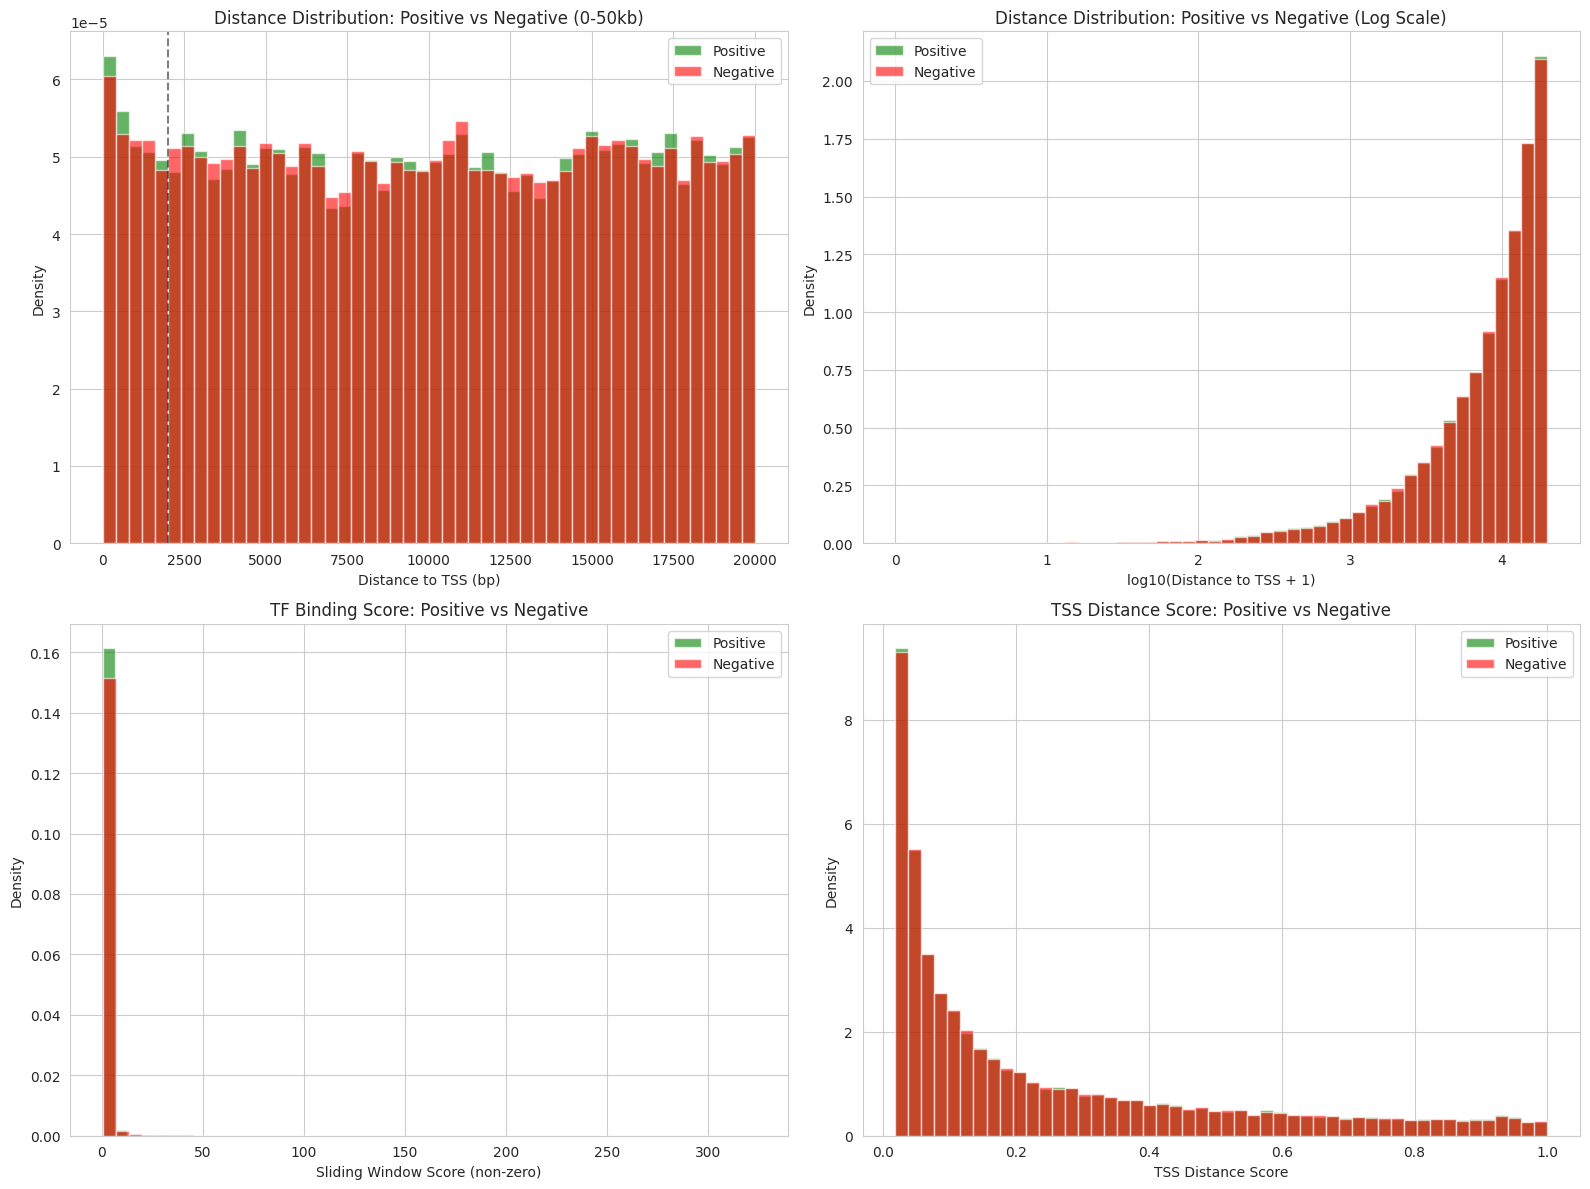


💡 KEY OBSERVATIONS:
   Look for clear separation between positive and negative distributions
   Features with good separation will be most predictive


In [30]:
# Visualize key feature distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distance comparison (0-50kb range)
pos_dist = positive_features['tss_distance'].values
neg_dist = negative_features['tss_distance'].values

pos_dist_50kb = pos_dist[pos_dist <= 50000]
neg_dist_50kb = neg_dist[neg_dist <= 50000]

axes[0, 0].hist(pos_dist_50kb, bins=50, alpha=0.6, label='Positive', color='green', density=True)
axes[0, 0].hist(neg_dist_50kb, bins=50, alpha=0.6, label='Negative', color='red', density=True)
axes[0, 0].set_xlabel('Distance to TSS (bp)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Distance Distribution: Positive vs Negative (0-50kb)')
axes[0, 0].legend()
axes[0, 0].axvline(2000, color='black', linestyle='--', alpha=0.5, label='2kb')

# 2. Distance comparison (log scale)
pos_dist_log = np.log10(pos_dist + 1)
neg_dist_log = np.log10(neg_dist + 1)

axes[0, 1].hist(pos_dist_log, bins=50, alpha=0.6, label='Positive', color='green', density=True)
axes[0, 1].hist(neg_dist_log, bins=50, alpha=0.6, label='Negative', color='red', density=True)
axes[0, 1].set_xlabel('log10(Distance to TSS + 1)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Distance Distribution: Positive vs Negative (Log Scale)')
axes[0, 1].legend()

# 3. Sliding window score comparison
pos_scores = positive_features['sliding_window_score'].dropna().values
neg_scores = negative_features['sliding_window_score'].dropna().values

# Only plot non-zero scores for better visualization
pos_scores_nonzero = pos_scores[pos_scores > 0]
neg_scores_nonzero = neg_scores[neg_scores > 0]

if len(pos_scores_nonzero) > 0 and len(neg_scores_nonzero) > 0:
    axes[1, 0].hist(pos_scores_nonzero, bins=50, alpha=0.6, label='Positive', color='green', density=True)
    axes[1, 0].hist(neg_scores_nonzero, bins=50, alpha=0.6, label='Negative', color='red', density=True)
    axes[1, 0].set_xlabel('Sliding Window Score (non-zero)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('TF Binding Score: Positive vs Negative')
    axes[1, 0].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'Insufficient non-zero scores', ha='center', va='center')
    axes[1, 0].set_title('TF Binding Score: Positive vs Negative')

# 4. TSS distance score comparison
pos_tss_score = positive_features['tss_distance_score'].values
neg_tss_score = negative_features['tss_distance_score'].values

axes[1, 1].hist(pos_tss_score, bins=50, alpha=0.6, label='Positive', color='green', density=True)
axes[1, 1].hist(neg_tss_score, bins=50, alpha=0.6, label='Negative', color='red', density=True)
axes[1, 1].set_xlabel('TSS Distance Score')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('TSS Distance Score: Positive vs Negative')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n💡 KEY OBSERVATIONS:")
print("   Look for clear separation between positive and negative distributions")
print("   Features with good separation will be most predictive")

### 3.7 Statistical Tests: Feature Discriminative Power

In [40]:
from scipy.stats import mannwhitneyu, ks_2samp

print("="*80)
print("STATISTICAL TESTS: POSITIVE vs NEGATIVE SEPARATION")
print("="*80)

# Test 1: TSS Distance
print("\n1. TSS Distance:")
u_stat, p_value = mannwhitneyu(positive_features['tss_distance'], 
                                negative_features['tss_distance'],
                                alternative='two-sided')
print(f"   Mann-Whitney U test: p-value = {p_value:.2e}")
if p_value < 0.001:
    print("   ✓ HIGHLY SIGNIFICANT difference in distance distributions")
else:
    print("   ✗ No significant difference")

# Test 2: Sliding Window Score
print("\n2. Sliding Window Score:")
pos_scores_clean = positive_features['sliding_window_score'].dropna()
neg_scores_clean = negative_features['sliding_window_score'].dropna()

if len(pos_scores_clean) > 0 and len(neg_scores_clean) > 0:
    u_stat, p_value = mannwhitneyu(pos_scores_clean, neg_scores_clean, alternative='two-sided')
    print(f"   Mann-Whitney U test: p-value = {p_value:.2e}")
    if p_value < 0.001:
        print("   ✓ HIGHLY SIGNIFICANT difference in binding score distributions")
    else:
        print("   ✗ No significant difference")
else:
    print("   ⚠️  Insufficient data for comparison")

# Effect sizes (Cohen's d)
print("\n3. Effect Sizes (Cohen's d):")

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d_distance = cohens_d(positive_features['tss_distance'], negative_features['tss_distance'])
print(f"   TSS Distance: d = {d_distance:.3f}")

if len(pos_scores_clean) > 0 and len(neg_scores_clean) > 0:
    d_score = cohens_d(pos_scores_clean, neg_scores_clean)
    print(f"   Sliding Window Score: d = {d_score:.3f}")

print("\n   Interpretation: |d| > 0.8 = large effect, 0.5-0.8 = medium, 0.2-0.5 = small")

STATISTICAL TESTS: POSITIVE vs NEGATIVE SEPARATION

1. TSS Distance:
   Mann-Whitney U test: p-value = 2.70e-01
   ✗ No significant difference

2. Sliding Window Score:
   Mann-Whitney U test: p-value = 0.00e+00
   ✓ HIGHLY SIGNIFICANT difference in binding score distributions

3. Effect Sizes (Cohen's d):
   TSS Distance: d = -0.001
   Sliding Window Score: d = 0.028

   Interpretation: |d| > 0.8 = large effect, 0.5-0.8 = medium, 0.2-0.5 = small


### 3.8 Save Processed Data for Model Training

In [33]:
# Save standardized datasets for model training
print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

output_dir = "data/processed_for_modeling"
os.makedirs(output_dir, exist_ok=True)

# Save key datasets
print("\nSaving standardized datasets...")

bear_grn_ground_truth_df.to_csv(f"{output_dir}/bear_grn_ground_truth.csv", index=False)
print(f"  ✓ {output_dir}/bear_grn_ground_truth.csv")

chip_atlas_tf_peak_tg_df.to_csv(f"{output_dir}/chip_atlas_tf_peak_tg.csv", index=False)
print(f"  ✓ {output_dir}/chip_atlas_tf_peak_tg.csv")

feature_df.to_parquet(f"{output_dir}/feature_dataframe_with_labels.parquet")
print(f"  ✓ {output_dir}/feature_dataframe_with_labels.parquet")

# Save summary statistics
summary_stats = {
    'bear_grn_edges': len(bear_grn_edges),
    'chip_atlas_edges': len(chip_atlas_edges),
    'edge_overlap': overlap,
    'bear_tfs': len(bear_tfs),
    'chip_tfs': len(chip_tfs),
    'tf_overlap': len(tf_overlap),
    'positive_edges': int(n_positive),
    'negative_edges': int(n_negative),
    'imbalance_ratio': float(n_negative/n_positive),
    'median_distance_positive': float(np.median(positive_features['tss_distance'])),
    'median_distance_negative': float(np.median(negative_features['tss_distance'])),
    'pct_within_2kb': float(within_2kb),
    'pct_within_5kb': float(within_5kb),
    'pct_within_10kb': float(within_10kb),
}

import json
with open(f"{output_dir}/summary_statistics.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"  ✓ {output_dir}/summary_statistics.json")

print("\n✓ All processed data saved!")

SAVING PROCESSED DATA

Saving standardized datasets...
  ✓ data/processed_for_modeling/bear_grn_ground_truth.csv
  ✓ data/processed_for_modeling/chip_atlas_tf_peak_tg.csv
  ✓ data/processed_for_modeling/feature_dataframe_with_labels.parquet
  ✓ data/processed_for_modeling/summary_statistics.json

✓ All processed data saved!


## Summary: Key Findings for Model Development

**Run all cells above, then document your findings here:**

### Distance Patterns
- What % of ChIP-Atlas edges are within 2kb? 5kb? 10kb?
  - 22.1% of ChIP peaks are within 2kb of TSS (promoter region)
  - 28.6% of ChIP peaks are within 5kb of TSS
  - 37.4% of ChIP peaks are within 10kb of TSS
  - 70.0% of ChIP peaks are within 50kb of TSS
- Is there clear separation between positive and negative edge distances?
  - No
- What distance threshold would maximize discrimination?
  - Can't Tell

### Ground Truth Overlap
- What % of BEAR-GRN edges appear in ChIP-Atlas?
    - 7.6% of BEAR-GRN edges in ChIP-Atlas
    - 10.0% of ChIP-Atlas edges in BEAR-GRN
- What % of TFs are shared between datasets?
    - BEAR-GRN TFs with RNA-seq = 46 / 272 (16.9%)
    - ChIP-Atlas TFs with RNA-seq: 40 / 131 (30.5%)
- Are there TFs in BEAR-GRN with NO ChIP-Atlas data?
    - BEAR-GRN TFs: 272
    - ChIP-Atlas TFs: 131
    - Overlapping TFs: 44
    - BEAR-GRN only TFs: 228
    - ChIP-Atlas only TFs: 87

### Feature Discriminative Power
1. TSS Distance:
   Mann-Whitney U test: p-value = 9.88e-01
   ✗ No significant difference

2. Sliding Window Score:
   Mann-Whitney U test: p-value = 0.00e+00
   ✓ HIGHLY SIGNIFICANT difference in binding score distributions

3. Effect Sizes (Cohen's d):
   TSS Distance: d = 0.000
   Sliding Window Score: d = 0.012

   Interpretation: |d| > 0.8 = large effect, 0.5-0.8 = medium, 0.2-0.5 = small

## Next Steps

After running this analysis:

1. **Document findings** in the summary section above
2. **Share key statistics** (distance distributions, overlap percentages, feature separation)
3. **Proceed to model development** with informed feature engineering and architecture decisions

---

**Stop here and run the full notebook to generate results!**